In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from luwiji.random_forest import illustration

In [3]:
from luwiji.xgboost import illustration

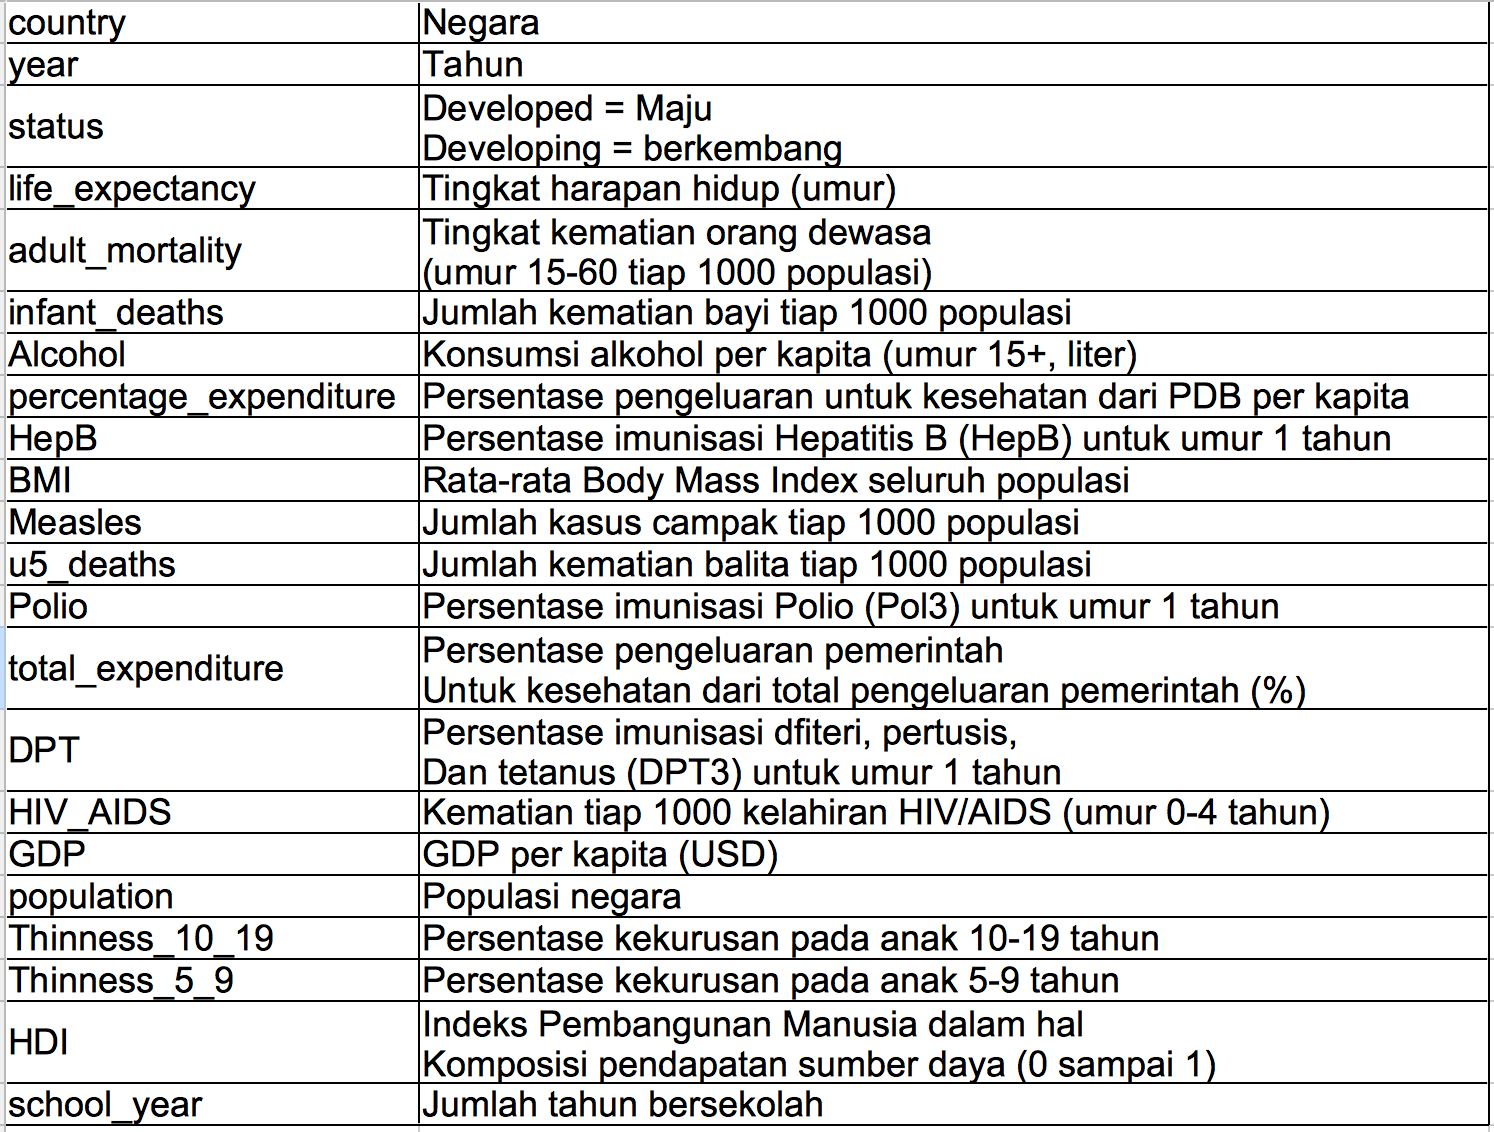

In [4]:
illustration.nomenklatur

# Import Data

In [5]:
df = pd.read_csv("data/life_expectancy.csv")
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


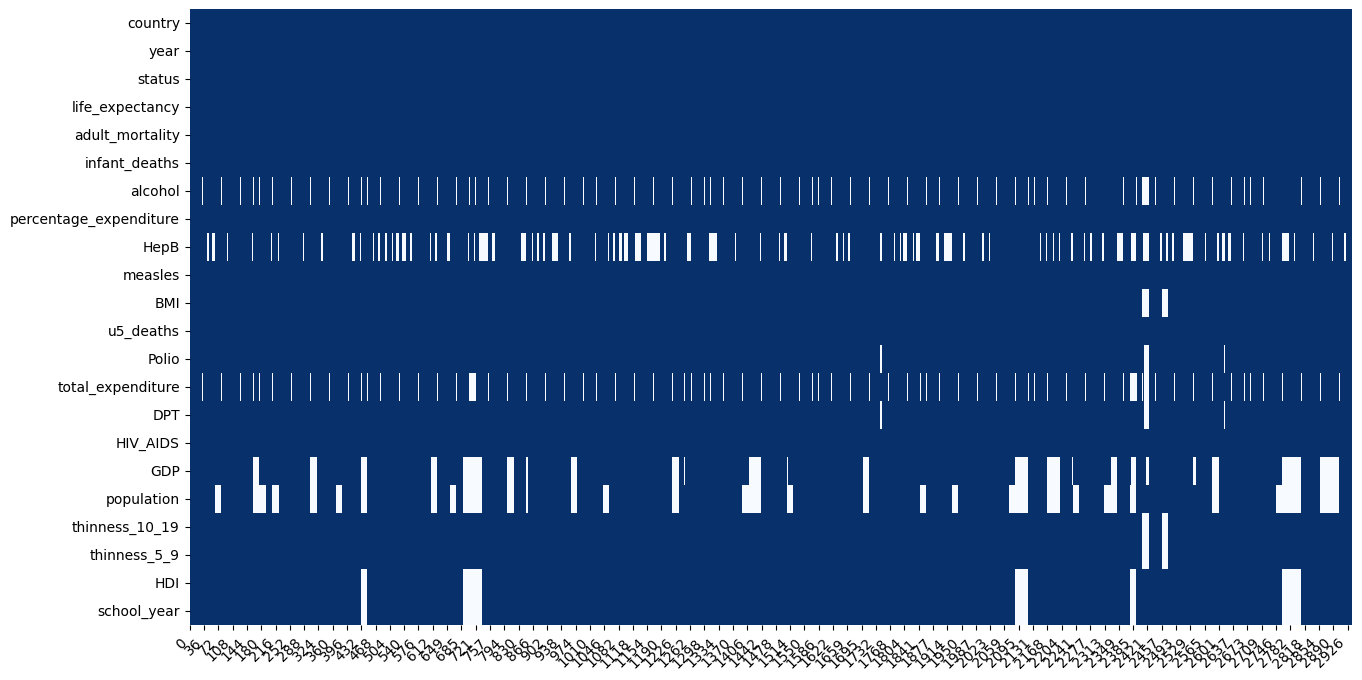

In [9]:
plot_missing_value(df)

In [8]:
df = df[~df.life_expectancy.isna()]

# Dataset Splitting

In [10]:
X = df.drop(columns="life_expectancy")
y = df.life_expectancy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

# Training

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from xgboost import XGBRegressor

In [14]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

subsample = subsampling baris (data)

colsample_bythree = max_feature = subsampling feature

gamma = min_impurity_decrease = minimum loss reduction for split to happen

reg_alpha dan reg_lambda itu regularization yang dibahas nanti. untuk sekarang bayangkan
mengurangi overfit.

In [28]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'HepB', 
                             'measles', 'BMI', 'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP', 
                             'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ("categoric", cat_pipe(), ['country', 'status'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, n_iter=50,cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.42066805426927745, 'algo__gamma': 1, 'algo__learning_rate': 0.035015835937029005, 'algo__max_depth': 9, 'algo__n_estimators': 176, 'algo__reg_alpha': 2.772824182801065, 'algo__reg_lambda': 0.0010661259689433889, 'algo__subsample': 0.5553736512887829}
0.9934437595893707 0.9584174729866337 0.9683689642689002


# Fase 2 Feature Important

In [29]:
from jcopml.feature_importance import mean_loss_decrease

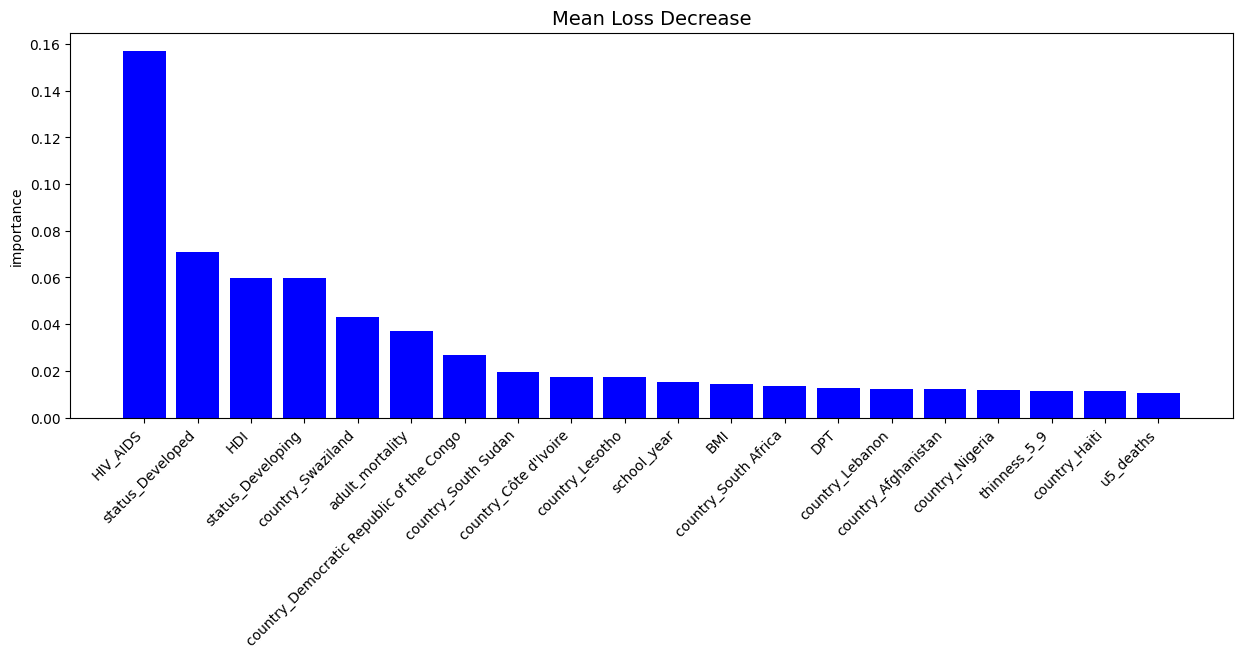

In [31]:
df_imp = mean_loss_decrease(X_train, model, plot=True, topk=20)

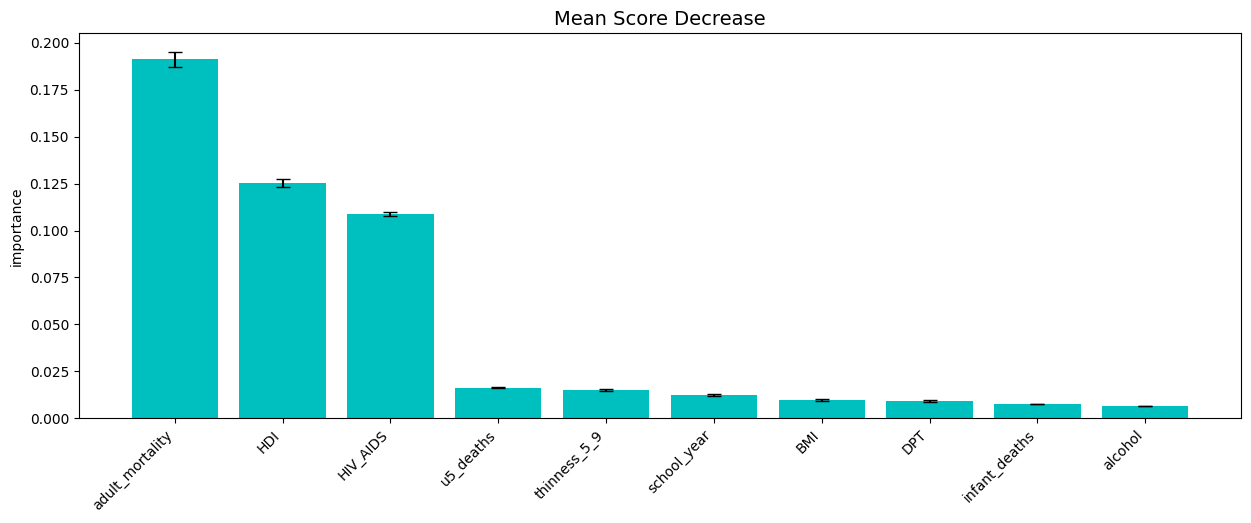

In [19]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [21]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['adult_mortality', 'HDI', 'HIV_AIDS', 'u5_deaths', 'thinness_5_9'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, n_iter=50,cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.8284250399306623, 'algo__gamma': 3, 'algo__learning_rate': 0.03253972566577117, 'algo__max_depth': 8, 'algo__n_estimators': 112, 'algo__reg_alpha': 0.002120199469953843, 'algo__reg_lambda': 0.0010489129591818502, 'algo__subsample': 0.6139472074743181}
0.987921729765059 0.9521948961953669 0.9637749734621613


In [22]:
list(df_imp.feature)[:10]

['adult_mortality',
 'HDI',
 'HIV_AIDS',
 'u5_deaths',
 'thinness_5_9',
 'school_year',
 'BMI',
 'DPT',
 'infant_deaths',
 'alcohol']

In [27]:
list(df_imp.feature)[:10]

['HIV_AIDS',
 'adult_mortality',
 'HDI',
 'school_year',
 'u5_deaths',
 'DPT',
 'BMI',
 'infant_deaths',
 'thinness_5_9',
 'alcohol']

In [32]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['adult_mortality','HDI','HIV_AIDS','u5_deaths','thinness_5_9','school_year',
                             'BMI','DPT','infant_deaths','alcohol'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, n_iter=50,cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.42066805426927745, 'algo__gamma': 1, 'algo__learning_rate': 0.035015835937029005, 'algo__max_depth': 9, 'algo__n_estimators': 176, 'algo__reg_alpha': 2.772824182801065, 'algo__reg_lambda': 0.0010661259689433889, 'algo__subsample': 0.5553736512887829}
0.9907431359511708 0.9559908706213994 0.9680152339198946


# Phase 3 : Polynomial

In [33]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(poly=2), ['adult_mortality','HDI','HIV_AIDS','u5_deaths','thinness_5_9','school_year',
                             'BMI','DPT','infant_deaths','alcohol'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, n_iter=50,cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.8658356038907615, 'algo__gamma': 1, 'algo__learning_rate': 0.02105025824748384, 'algo__max_depth': 6, 'algo__n_estimators': 183, 'algo__reg_alpha': 0.21025507424094825, 'algo__reg_lambda': 0.0308411856961828, 'algo__subsample': 0.7700667212288893, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9820824580043693 0.9534924752406172 0.9648522379137502


# New Teknik => BayesianSearchCV

In [34]:
from skopt import BayesSearchCV
from jcopml.tuning import bayes_search_params as bsp

In [35]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['year', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'HepB', 
                             'measles', 'BMI', 'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP', 
                             'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year']),
    ("categoric", cat_pipe(), ['country', 'status'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = BayesSearchCV(pipeline, bsp.xgb_params, n_iter=50, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

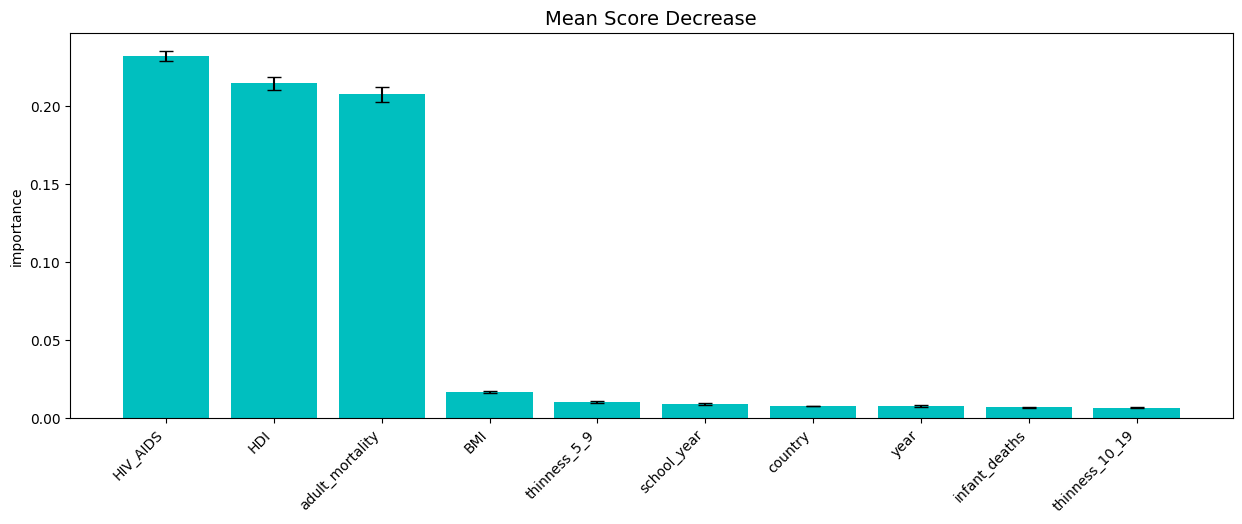

In [36]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [37]:
list(df_imp.feature)

['HIV_AIDS',
 'HDI',
 'adult_mortality',
 'BMI',
 'thinness_5_9',
 'school_year',
 'country',
 'year',
 'infant_deaths',
 'thinness_10_19']

In [38]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['HIV_AIDS', 'HDI', 'adult_mortality', 'BMI', 'thinness_5_9', 'school_year',
                             'year', 'infant_deaths', 'thinness_10_19']),
    ("categoric", cat_pipe(), ['country'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = BayesSearchCV(pipeline, bsp.xgb_params, n_iter=50, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

# Phase 3

In [40]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(poly=2), ['HIV_AIDS', 'HDI', 'adult_mortality', 'BMI', 'thinness_5_9', 'school_year',
                             'year', 'infant_deaths', 'thinness_10_19']),
    ("categoric", cat_pipe(), ['country'])
])
pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBRegressor(n_jobs=-1, random_state=42))
])

model = BayesSearchCV(pipeline, bsp.xgb_poly_params, n_iter=50, cv=3, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

# Save Model

In [42]:
save_model(model.best_estimator_, "xgb_regressor_tingkat_harapan_hidup.pkl")

Model is pickled as model/xgb_regressor_tingkat_harapan_hidup.pkl
